# Stable Diffusion を構成する要素を用いた実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/4-3_stable-diffusion_components.ipynb)

参考: https://github.com/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb

## 準備

In [1]:
!pip install -qq py-img-gen

In [2]:
import warnings

import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
dtype = torch.float16
variant = "fp16"
seed = 42

warnings.simplefilter("ignore", FutureWarning)

## 読み込むモデル名を指定

In [3]:
sd_model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"
clip_model_id = "openai/clip-vit-large-patch14"

## Image Encoder である VAE モデルの読み込み

In [4]:
from diffusers import AutoencoderKL
from diffusers.image_processor import VaeImageProcessor

vae = AutoencoderKL.from_pretrained(
    sd_model_id,
    subfolder="vae",
)
vae = vae.to(device)

scale_factor = vae.config.scaling_factor
image_processor = VaeImageProcessor(
    vae_scale_factor=scale_factor
)

## Denoiser である UNet モデルの読み込み

In [5]:
from diffusers import UNet2DConditionModel

unet = UNet2DConditionModel.from_pretrained(
    sd_model_id,
    subfolder="unet",
)
unet = unet.to(device)

## Text encoder である CLIP モデルの読み込み

In [6]:
from transformers import CLIPTextModel, CLIPTokenizer

text_encoder = CLIPTextModel.from_pretrained(clip_model_id)
text_encoder = text_encoder.to(device)

tokenizer = CLIPTokenizer.from_pretrained(clip_model_id)

## Noise scheduler である LMSDiscreteScheduler の読み込み

In [7]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained(
    sd_model_id, subfolder="scheduler"
)

## 画像生成する際のハイパーパラメータの指定

In [8]:
prompt = "a photograph of an astronaut riding a horse"

width = height = 512  # 生成画像の幅と高さ

# ノイズ除去のステップ数; デフォルト値を使用
num_inference_steps = 50
# classifier-free guidance の guidance scale
guidance_scale = 7.5
# 乱数生成器に指定されたシード値を設定
generator = torch.manual_seed(seed)
# バッチサイズ
batch_size = 1

## テキスト条件埋め込みの取得

In [9]:
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt",
)
print(text_input)

{'input_ids': tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}


In [10]:
with torch.no_grad():
    outputs = text_encoder(text_input.input_ids.to(device))
    text_embeddings = outputs.last_hidden_state

print(text_embeddings.size())

torch.Size([1, 77, 768])


## テキスト条件無し埋め込みの取得

In [11]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt",
)
with torch.no_grad():
    outputs = text_encoder(
        uncond_input.input_ids.to(device)
    )
    uncond_embeddings = outputs.last_hidden_state

print(uncond_embeddings.size())

torch.Size([1, 77, 768])


## 2つの条件埋め込みの結合

In [12]:
text_embeddings = torch.cat(
    [uncond_embeddings, text_embeddings]
)

print(text_embeddings.size())

torch.Size([2, 77, 768])


## 潜在表現（ノイズ画像）の取得

In [13]:
latent_size = (
    batch_size,
    unet.config.in_channels,
    height // 8,
    width // 8,
)
latents = torch.randn(
    size=latent_size,
    generator=generator,
)
latents = latents.to(device)
print(latents.size())

torch.Size([1, 4, 64, 64])


## Noise scheduler の設定 とそれに対応した潜在表現の取得

In [14]:
scheduler.set_timesteps(num_inference_steps)

latents *= scheduler.init_noise_sigma

## 逆拡散過程を用いたノイズ除去による潜在表現の生成

In [15]:
@torch.no_grad()
def reverse_diffusion_process(
    latents: torch.Tensor,
) -> torch.Tensor:
    # Classifier-free guidance で 2 回 のモデル forward 計算を
    # 避けるために、潜在表現を 2 つににしてバッチ化します
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(
        latent_model_input, t
    )

    # U-Net を元にノイズ残差を予測します
    noise_pred = unet(
        latent_model_input,
        t,
        encoder_hidden_states=text_embeddings,
    ).sample

    # Classifier-free guidance を適用します
    # - 計算されたノイズ残差に対して、無条件/条件付き埋め込みに分割
    # - 分割されたそれぞれを用いて classifier-free guidance を計算
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )

    # 現在のステップ x_t から前のステップ x_{t-1} を予測
    latents = scheduler.step(
        noise_pred, t, latents
    ).prev_sample

    return latents

In [16]:
from tqdm.auto import tqdm

for t in tqdm(scheduler.timesteps):
    latents = reverse_diffusion_process(latents)

  0%|          | 0/50 [00:00<?, ?it/s]

## 生成された潜在表現のデコードと生成結果の可視化

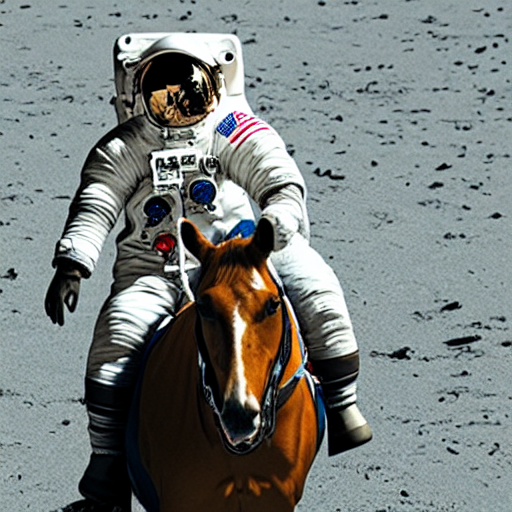

In [17]:
from diffusers.image_processor import VaeImageProcessor

with torch.no_grad():
    images = vae.decode(
        latents / scale_factor,
        generator=torch.manual_seed(seed),
    ).sample

image_processor = VaeImageProcessor(
    vae_scale_factor=scale_factor
)
images = image_processor.postprocess(images)

images[0]